In [1]:
%matplotlib inline  

In [2]:
import torch
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import torch.utils.data as data_utils
import pickle
import os
import warnings 
warnings.simplefilter("ignore", UserWarning)

In [3]:
os.chdir("..")

In [4]:
from Prior_optimization.gpr import GPR
from Prior_optimization import kernels, mean_functions, priors
from Networks.gaussian_reparam_mlp import GaussianMLPReparameterization
from Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Networks.mlp import MLP
from Samplers.likelihoods import LikGaussian
from Prior_optimization.priors import FixedGaussianPrior, OptimGaussianPrior
from Utilities.rand_generators import MeasureSetGenerator, GridGenerator
from Utilities.normalization import normalize_data
from Utilities.exp_utils import get_input_range
from Metrics.sampling import compute_rhat_regression
from Metrics import uncertainty as uncertainty_metrics
from Networks.regression_net import RegressionNet
from Networks.mlp_masked import MLPMasked
from Networks.regression_net_masked import RegressionNetMasked
from Prior_optimization.sinkhorn_optimisation import SinkhornMapper
from Utilities import util
from Utilities.priors import LogNormal

In [5]:
mpl.rcParams['figure.dpi'] = 100

In [6]:
SEED = 123
util.set_seed(SEED)

In [7]:
# Network architecture
n_units = 100
n_hidden = 1
activation_fn = "tanh"

In [8]:
# Dataset configurations
n_splits = 10
dataset = "boston"
data_dir = "./data/uci"
noise_var = 0.1

In [9]:
# setting device on GPU if available, else CPU
n_gpu = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} \n')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    n_gpu +=1

Using device: cuda 

NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# 1. Optimized Gaussian Prior

In [10]:
out_dir = "./exp/uci/optim_gaussian"
util.ensure_dir(out_dir)

## 1.1 Optimize the prior

In [11]:
num_iters = 200  # Number of iteterations of Wasserstein optimization
lr = 0.05        # The learning rate
n_samples = 128  # The mini-batch size
lambd_sd = torch.tensor([2.]).to(device) # Vetcor of penalization terms
D = 3            # Depth for pruning of standard deviations
num_samples = 30
num_iters_sd = 10000
print_every = 100
n_data = 128

In [ ]:
masks_list = []
for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    # Load the dataset
    saved_dir = os.path.join(out_dir, str(split_id))
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    X_train_, y_train_, X_test_, y_test_, y_mean, y_std = normalize_data(
            X_train, y_train, X_test, y_test)
    x_min, x_max = get_input_range(X_train_, X_test_)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    # Initialize the measurement set generator
    rand_generator = MeasureSetGenerator(X_train_, x_min, x_max, 0.7)
    
    # Initialize the mean and covariance function of the target hierarchical GP prior
    mean = mean_functions.Zero()
    
    lengthscale = math.sqrt(2. * input_dim)
    variance = 1.
    kernel = kernels.RBF(input_dim=input_dim,
                         lengthscales=torch.tensor([lengthscale], dtype=torch.double),
                         variance=torch.tensor([variance], dtype=torch.double), ARD=True)

    # Place hyper-priors on lengthscales and variances
    kernel.lengthscales.prior = LogNormal(
            torch.ones([input_dim]) * math.log(lengthscale),
            torch.ones([input_dim]) * 1.)
    kernel.variance.prior = LogNormal(
            torch.ones([1]) * 0.1,
            torch.ones([1]) * 1.)
        
    # Initialize the GP model
    gp = GPR(X=torch.from_numpy(X_train_), Y=torch.from_numpy(y_train_).reshape([-1, 1]),
             kern=kernel, mean_function=mean)
    gp.likelihood.variance.set(noise_var)
    gp = gp.to(device)
    
    # Initialize tunable MLP prior
    hidden_dims = [n_units] * n_hidden
    mlp_reparam = FactorizedGaussianMLPReparameterization(input_dim, output_dim,
        hidden_dims, D = D, activation_fn=activation_fn, scaled_variance=True, device=device)
    # Perform optimization
    mapper = SinkhornMapper(out_dir=saved_dir).to(device)
    y_train_tensor = torch.tensor(y_train).to(device)  # Assumes y is 1D: (batch_size,)
    y_train = y_train_tensor[:, None, None].expand(-1, num_samples, 1)
    p_hist, loss_hist = mapper.optimize_sparse(net = mlp_reparam, gp = gp, data_generator = rand_generator, 
            lambd= lambd_sd, n_data = n_data, num_iters = num_iters_sd, print_every=print_every, output_dim = 1, 
            D= D, X_train = torch.tensor(X_train), y_train= y_train, n_samples = num_samples)
    path = os.path.join(saved_dir, "loss_values.log")
    if not os.path.isfile(saved_dir):
        os.makedirs(saved_dir, exist_ok=True)
    np.savetxt(path, loss_hist, fmt='%.6e')
    path = os.path.join(saved_dir, "pruned_values.log")
    if not os.path.isfile(saved_dir):
        os.makedirs(saved_dir, exist_ok=True)
    np.savetxt(path, p_hist, fmt='%.6e')
    print("----" * 20)
    masks_list.append(mlp_reparam.get_det_masks())
# Save the masks
with open(os.path.join(out_dir, "masks_list.pkl"), "wb") as f:
    pickle.dump(masks_list, f)

Loading split 1 of boston dataset
>>> Iteration #   1: Sinkhorn Dist 42.5757 Number of pruned stochastic weights: 0
>>> Iteration # 100: Sinkhorn Dist 24.4243 Number of pruned stochastic weights: 0
>>> Iteration # 200: Sinkhorn Dist 28.2920 Number of pruned stochastic weights: 0
>>> Iteration # 300: Sinkhorn Dist 22.9162 Number of pruned stochastic weights: 1
>>> Iteration # 400: Sinkhorn Dist 33.5053 Number of pruned stochastic weights: 3
>>> Iteration # 500: Sinkhorn Dist 32.0044 Number of pruned stochastic weights: 7
>>> Iteration # 600: Sinkhorn Dist 35.8917 Number of pruned stochastic weights: 11
>>> Iteration # 700: Sinkhorn Dist 25.4768 Number of pruned stochastic weights: 24
>>> Iteration # 800: Sinkhorn Dist 27.3003 Number of pruned stochastic weights: 39
>>> Iteration # 900: Sinkhorn Dist 27.9885 Number of pruned stochastic weights: 51
>>> Iteration # 1000: Sinkhorn Dist 35.7554 Number of pruned stochastic weights: 66
>>> Iteration # 1100: Sinkhorn Dist 21.4929 Number of prun

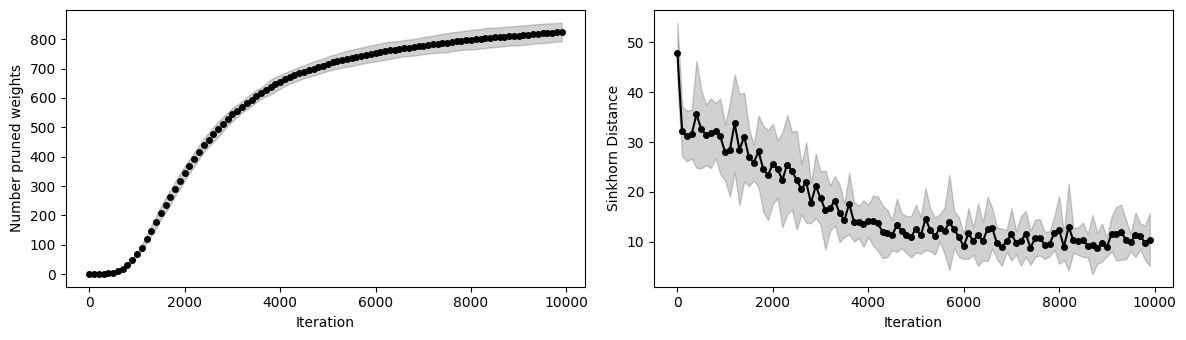

In [13]:
# Visualize the convergence
lossdist_data = []
pruned_vals_data = []
for i in range(0, n_splits):
    lossdist_file = os.path.join(out_dir, str(i), "loss_values.log")
    pruned_vals_file = os.path.join(out_dir, str(i), "pruned_values.log")
    lossdist_data.append(np.loadtxt(lossdist_file))
    pruned_vals_data.append(np.loadtxt(pruned_vals_file))

lossdist_vals = np.stack(lossdist_data)
pruned_vals = np.stack(pruned_vals_data)
indices = np.arange(num_iters_sd)[::100]
mean_loss = lossdist_vals.mean(0)
std_loss = lossdist_vals.std(0)
mean_pruned = pruned_vals.mean(0)
std_pruned = pruned_vals.std(0)

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))  
axes[0].plot(indices, mean_pruned[indices], "ko", ms=4)
axes[0].fill_between(indices, mean_pruned[indices] - std_pruned[indices],
                 mean_pruned[indices] + std_pruned[indices], alpha=0.18, color="k")
axes[0].set_ylabel("Number pruned weights")
axes[0].set_xlabel("Iteration")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(indices, mean_loss[indices], "-ko", ms=4)
axes[1].fill_between(indices, mean_loss[indices]-std_loss[indices],
                     mean_loss[indices]+std_loss[indices], alpha = 0.18, color = "k")
axes[1].set_ylabel("Sinkhorn Distance")
axes[1].set_xlabel("Iteration")

plt.tight_layout()
plt.show()

## 1.2 Posterior Inference

### No Prevention from Overfitting

In [12]:
sampling_configs = {
    "batch_size": 32,                 # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 1000,         # Number of burn-in steps
    "keep_every": 1000,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5
}

# Load the masks
with open(os.path.join(out_dir, "masks_list.pkl"), "rb") as f:
    masks_list = pickle.load(f)

In [ ]:
results_no = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    saved_dir = os.path.join(out_dir, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    # Initialize the neural network and likelihood modules
    weight_mask, bias_mask = masks_list[split_id]
    net = MLPMasked(input_dim, output_dim, [n_units] * n_hidden, activation_fn, weight_mask, 
                    bias_mask, device = device)
    net = net.to(device)
    likelihood = LikGaussian(noise_var)
    
    # Load the optimized prior
    ckpt_path = os.path.join(out_dir, str(split_id), "ckpts", "sparse-it-{}.ckpt".format(num_iters_sd))
    prior = OptimGaussianPrior(ckpt_path)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir, str(split_id))
    bayes_net = RegressionNetMasked(net, likelihood, prior, saved_dir, n_gpu=n_gpu)
    
    # Start sampling
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results_no['rmse'].append(rmse)
    results_no['nll'].append(nll)

Loading split 1 of boston dataset
Chain: 1
Samples #     5 : NLL =  2.6267e+00 RMSE = 2.8552e+00 
Samples #    10 : NLL =  2.6073e+00 RMSE = 2.5133e+00 
Samples #    15 : NLL =  2.6205e+00 RMSE = 2.3470e+00 
Samples #    20 : NLL =  2.6341e+00 RMSE = 2.2313e+00 
Samples #    25 : NLL =  2.6334e+00 RMSE = 2.1880e+00 
Samples #    30 : NLL =  2.6522e+00 RMSE = 2.1804e+00 
Chain: 2
Samples #    35 : NLL =  2.6087e+00 RMSE = 1.9148e+00 
Samples #    40 : NLL =  2.5822e+00 RMSE = 1.7448e+00 
Samples #    45 : NLL =  2.5628e+00 RMSE = 1.6412e+00 
Samples #    50 : NLL =  2.5505e+00 RMSE = 1.5718e+00 
Samples #    55 : NLL =  2.5363e+00 RMSE = 1.5068e+00 
Samples #    60 : NLL =  2.5256e+00 RMSE = 1.4600e+00 
Chain: 3
Samples #    65 : NLL =  2.5156e+00 RMSE = 1.3787e+00 
Samples #    70 : NLL =  2.5086e+00 RMSE = 1.3221e+00 
Samples #    75 : NLL =  2.5011e+00 RMSE = 1.2653e+00 
Samples #    80 : NLL =  2.4969e+00 RMSE = 1.2307e+00 
Samples #    85 : NLL =  2.4946e+00 RMSE = 1.1929e+00 
Samp

In [ ]:
result_df_no = pd.DataFrame(results_no)
result_df_no.to_csv(os.path.join(out_dir, "optim_results.csv"), sep="\t", index=False)

### Dropout to prevent overfitting

In [ ]:
sampling_configs = {
    "batch_size": 32,                 # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,         # Number of burn-in steps
    "keep_every": 2000,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5,
    "prevent_overfitting" : "Dropout"
}

In [ ]:
results_do = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    saved_dir = os.path.join(out_dir, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1

    # Initialize the neural network and likelihood modules
    weight_mask, bias_mask = masks_list[split_id]
    net = MLPMasked(input_dim, output_dim, [n_units] * n_hidden, activation_fn, weight_mask, 
                    bias_mask)
    net = net.to(device)
    likelihood = LikGaussian(noise_var)
    
    # Load the optimized prior
    ckpt_path = os.path.join(out_dir, str(split_id), "ckpts", "sparse-it-{}.ckpt".format(num_iters_sd))
    prior = OptimGaussianPrior(ckpt_path)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir, str(split_id))
    bayes_net = RegressionNetMasked(net, likelihood, prior, saved_dir, n_gpu=n_gpu)
    
    # Start sampling
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results_do['rmse'].append(rmse)
    results_do['nll'].append(nll)

In [ ]:
result_df_do = pd.DataFrame(results_do)
result_df_do.to_csv(os.path.join(out_dir, "optim_results_dropout.csv"), sep="\t", index=False)

### Early Stopping to Prevent Overfitting

In [ ]:
sampling_configs = {
    "batch_size": 32,                 # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,         # Number of burn-in steps
    "keep_every": 2000,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5,
    "prevent_overfitting" : "Early Stopping"
}

In [ ]:
results_es = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    saved_dir = os.path.join(out_dir, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1

    # Initialize the neural network and likelihood modules
    weight_mask, bias_mask = masks_list[split_id]
    net = MLPMasked(input_dim, output_dim, [n_units] * n_hidden, activation_fn, 
                    weight_mask, bias_mask)
    net = net.to(device)
    likelihood = LikGaussian(noise_var)
    
    # Load the optimized prior
    ckpt_path = os.path.join(out_dir, str(split_id), "ckpts", "sparse-it-{}.ckpt".format(num_iters_sd))
    prior = OptimGaussianPrior(ckpt_path)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir, str(split_id))
    bayes_net = RegressionNetMasked(net, likelihood, prior, saved_dir, n_gpu=n_gpu)
    
    # Start sampling
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results_es['rmse'].append(rmse)
    results_es['nll'].append(nll)

In [ ]:
result_df_es = pd.DataFrame(results_es)
result_df_es.to_csv(os.path.join(out_dir, "optim_results_early_stoppping.csv"), sep="\t", index=False)

### WCP to regularize

In [ ]:
sampling_configs = {
    "batch_size": 32,                 # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,         # Number of burn-in steps
    "keep_every": 2000,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5,
    "prevent_overfitting" : "WCP"
}

In [ ]:
results_wcp = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id+1, dataset))
    saved_dir = os.path.join(out_dir, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1

    # Initialize the neural network and likelihood modules
    weight_mask, bias_mask = masks_list[split_id]
    net = MLPMasked(input_dim, output_dim, [n_units] * n_hidden, activation_fn, weight_mask,
                    bias_mask)
    net = net.to(device)
    likelihood = LikGaussian(noise_var)
    
    # Load the optimized prior
    ckpt_path = os.path.join(out_dir, str(split_id), "ckpts", "sparse-it-{}.ckpt".format(num_iters_sd))
    prior = OptimGaussianPrior(ckpt_path)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir, str(split_id))
    bayes_net = RegressionNetMasked(net, likelihood, prior, saved_dir, n_gpu=n_gpu)
    
    # Start sampling
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results_wcp['rmse'].append(rmse)
    results_wcp['nll'].append(nll)

In [ ]:
result_df_wcp = pd.DataFrame(results_wcp)
result_df_wcp.to_csv(os.path.join(out_dir, "optim_results_wcp.csv"), sep="\t", index=False)

### Final Result

In [ ]:
# read all the results:
result_df_wcp = pd.read_csv(os.path.join(out_dir, "optim_results_wcp.csv"), sep="\t")
result_df_es = pd.read_csv(os.path.join(out_dir, "optim_results_early_stoppping.csv"), sep = "\t")
result_df_do = pd.read_csv(os.path.join(out_dir, "optim_results_dropout.csv"), sep = "\t")
result_df_no = pd.read_csv(os.path.join(out_dir, "optim_results.csv"), sep = "\t")

data_rmse = [result_df_no["rmse"], result_df_do["rmse"], result_df_es["rmse"], result_df_wcp["rmse"]]
data_nll = [result_df_no["nll"], result_df_do["nll"], result_df_es["nll"], result_df_wcp["nll"]]
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))

# RMSE box plot
axes[0].boxplot(data_rmse, labels=['No prevention', 'Dropout', 'Early Stopping', 'WCP'])
axes[0].set_ylabel("RMSE $\downarrow$")
axes[0].set_title("RMSE Comparison")
axes[0].grid(True)

# NLL box plot
axes[1].boxplot(data_nll, labels=['No prevention', 'Dropout', 'Early Stopping', 'WCP'])
axes[1].set_ylabel("NLL $\downarrow$")
axes[1].set_title("NLL Comparison")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
print("Final results no prevention from overfitting:")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df_no['rmse'].mean()), float(result_df_no['rmse'].std()),
        float(result_df_no['nll'].mean()), float(result_df_no['nll'].std())))
print("\nFinal results using dropout:")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df_do['rmse'].mean()), float(result_df_do['rmse'].std()),
        float(result_df_do['nll'].mean()), float(result_df_do['nll'].std())))
print("\nFinal results using Early Stopping:")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df_es['rmse'].mean()), float(result_df_es['rmse'].std()),
        float(result_df_es['nll'].mean()), float(result_df_es['nll'].std())))
print("\nFinal results using WCP:")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df_wcp['rmse'].mean()), float(result_df_wcp['rmse'].std()),
        float(result_df_wcp['nll'].mean()), float(result_df_wcp['nll'].std())))